In [1]:
import pandas as pd
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import split, col, explode, to_date, unix_timestamp, to_timestamp, year, month, dayofmonth, dayofweek, hour, minute, lower

# ETL

## Create a cluster

In [2]:
## Launch Amazon EMR Cluster
#!aws emr create-cluster \
#    --name etl_yelp_cluster \
#    --use-default-roles \
#    --release-label emr-5.28.0  \
#    --instance-count 3 \
#    --applications Name=Spark \
#    --ec2-attributes KeyName=spark_etl_yelp_cluster,SubnetId=subnet-04a815f2d9bdc8b44 \
#    --instance-type m5.xlarge \
#    --profile yelp

In [3]:
from pyspark.sql import SparkSession
spark = (
    SparkSession
        .builder
        .appName("etl")
        .config("spark.driver.memory", "8g")
        .getOrCreate()
    
)

## Read data and convert to parquet

### Business dataset

In [4]:
sdf_business = spark.read.json("data/input/yelp_academic_dataset_business.json")

In [5]:
sdf_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [6]:
def flatten_df(nested_df):
    flat_cols = [c[0] for c in nested_df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in nested_df.dtypes if c[1][:6] == 'struct']

    flat_df = nested_df.select(flat_cols +
                               [F.col(nc+'.'+c).alias(nc+'_'+c)
                                for nc in nested_cols
                                for c in nested_df.select(nc+'.*').columns])
    return flat_df

In [7]:
sdf_business_flattened = flatten_df(sdf_business)
sdf_business_flattened.printSchema()

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)
 |-- attributes_AcceptsInsurance: string (nullable = true)
 |-- attributes_AgesAllowed: string (nullable = true)
 |-- attributes_Alcohol: string (nullable = true)
 |-- attributes_Ambience: string (nullable = true)
 |-- attributes_BYOB: string (nullable = true)
 |-- attributes_BYOBCorkage: string (nullable = true)
 |-- attributes_BestNights: string (nullable = true)
 |-- attributes_BikeParking: string (nullable = true)
 |-- attributes_BusinessAcceptsBitcoin: string (nullable = true)
 |-- attributes_BusinessAcceptsCred

In [8]:
sdf_business_flattened.createOrReplaceTempView("business")

In [9]:
spark.sql("SELECT COUNT(business_id) FROM business").show()

+------------------+
|count(business_id)|
+------------------+
|            160585|
+------------------+



In [10]:
spark.sql("SELECT DISTINCT COUNT(business_id) FROM business").show()

+------------------+
|count(business_id)|
+------------------+
|            160585|
+------------------+



In [11]:
spark.sql("SELECT COUNT(DISTINCT categories) FROM business").show()

+--------------------------+
|count(DISTINCT categories)|
+--------------------------+
|                     88115|
+--------------------------+



In [12]:
spark.sql("SELECT categories, COUNT(*) AS n FROM business GROUP BY categories ORDER BY n DESC").show()

+--------------------+---+
|          categories|  n|
+--------------------+---+
|Beauty & Spas, Ha...|757|
|  Restaurants, Pizza|748|
|Hair Salons, Beau...|742|
|  Pizza, Restaurants|740|
|Beauty & Spas, Na...|734|
|Nail Salons, Beau...|712|
|  Coffee & Tea, Food|703|
|  Food, Coffee & Tea|680|
|Restaurants, Chinese|601|
|Chinese, Restaurants|588|
|Mexican, Restaurants|549|
|Restaurants, Mexican|507|
|Automotive, Auto ...|444|
|Auto Repair, Auto...|422|
|Financial Service...|390|
|Home Services, Re...|363|
|Banks & Credit Un...|347|
|Real Estate, Home...|345|
|Real Estate, Apar...|344|
|Home Services, Ap...|342|
+--------------------+---+
only showing top 20 rows



In [13]:
spark.sql("SELECT COUNT(DISTINCT city) FROM business").show()

+--------------------+
|count(DISTINCT city)|
+--------------------+
|                 836|
+--------------------+



In [14]:
spark.sql("SELECT city, COUNT(*) AS n FROM business GROUP BY city ORDER BY n DESC").show()

+---------------+-----+
|           city|    n|
+---------------+-----+
|         Austin|22416|
|       Portland|18203|
|      Vancouver|13330|
|        Atlanta|12612|
|        Orlando|10637|
|         Boston| 8263|
|       Columbus| 6634|
|        Boulder| 2542|
|      Cambridge| 2433|
|      Beaverton| 2252|
|       Richmond| 1791|
|        Burnaby| 1725|
|      Kissimmee| 1713|
|        Decatur| 1411|
|    Winter Park| 1288|
|     Somerville| 1265|
|         Quincy| 1093|
|      Brookline|  986|
|North Vancouver|  926|
|         Tigard|  916|
+---------------+-----+
only showing top 20 rows



In [15]:
spark.sql("SELECT COUNT(DISTINCT state) FROM business").show()

+---------------------+
|count(DISTINCT state)|
+---------------------+
|                   31|
+---------------------+



In [16]:
spark.sql("SELECT state, COUNT(*) AS n FROM business GROUP BY state ORDER BY n DESC").show()

+-----+-----+
|state|    n|
+-----+-----+
|   MA|36012|
|   OR|25175|
|   TX|24485|
|   FL|21907|
|   GA|18090|
|   BC|17298|
|   OH|11258|
|   CO| 3198|
|   WA| 3121|
|   CA|   13|
|   NH|    4|
|   AZ|    2|
|   NY|    2|
|   ON|    2|
|   VA|    2|
|   DC|    1|
|   WI|    1|
|   MI|    1|
|   IL|    1|
|   ME|    1|
+-----+-----+
only showing top 20 rows



### Metroplitan Areas

This dataset does not exist in the original information. The catalog of metropolitan areas is built by running a Cluster Analysis using KMeans. We know from the documentation that the dataset includes locations from 8 metropolitan areas, so a KMeans cluster with 8 clusters is estimated. Then the average latitude and loingitude is calculated for each group and looked up in google maps to find out the metropolitan area and state.

In [17]:
df_business_points = (
    spark.sql(
        """SELECT business_id, state, city, latitude, longitude 
        FROM business 
        ORDER BY state""")
    .toPandas()
)

No Null values were found.

In [18]:
df_business_points.isnull().sum()

business_id    0
state          0
city           0
latitude       0
longitude      0
dtype: int64

Estimate clusters

In [19]:
from sklearn.cluster import KMeans
k = 9
kmeans = KMeans(n_clusters=k, max_iter = 10000, random_state = 2502)
df_business_points['cluster'] = kmeans.fit_predict(df_business_points[['latitude', 'longitude']])
df_business_points['cluster'] = df_business_points.cluster.astype('category')

In [20]:
df_business_points.cluster.value_counts()

2    36021
1    28301
3    24487
5    21913
0    18094
7    17305
6    11262
4     3201
8        1
Name: cluster, dtype: int64

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


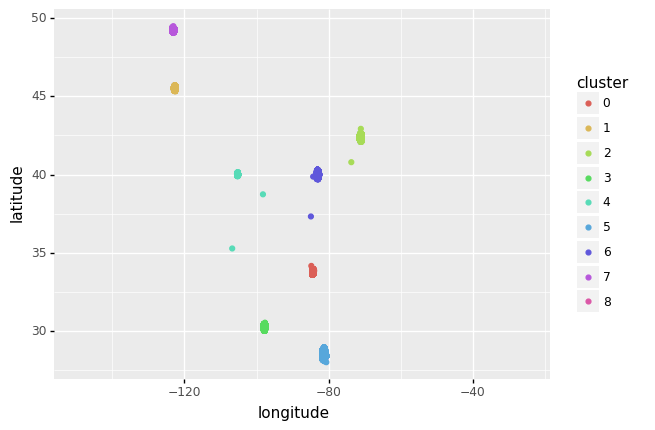

<ggplot: (301847565)>

In [21]:
from plotnine import *
(
    ggplot(df_business_points, aes(x = 'longitude', y= 'latitude', color = 'cluster')) + 
    geom_point() + 
    scale_x_continuous(limits = [-150, -25]))

In [22]:
metropolitan_areas = [
    'Denver, Colorado', 
    'Columbus, Ohio',
    'Portland, Oregon & Vancouver, Washington',
    'Cambridge, Masachusetts',
    'Austin, Texas',
    'Orlando, Florida',
    'Atlanta, Georgia',
    'Vancouver, British Columbia',
    'Cambridge, Masachusetts'
]

df_metro_area_catalog = (
    df_business_points.groupby(['cluster'])
        .mean()
        .reset_index()
        .assign(metropolitan_area = metropolitan_areas)
)
df_metro_area_catalog

,cluster,latitude,longitude,metropolitan_area
0,0,33.813396,-84.371422,"Denver, Colorado"
1,1,45.514771,-122.666759,"Columbus, Ohio"
2,2,42.368284,-71.097355,"Portland, Oregon & Vancouver, Washington"
3,3,30.293938,-97.768996,"Cambridge, Masachusetts"
4,4,40.012371,-105.233104,"Austin, Texas"
5,5,28.527385,-81.378905,"Orlando, Florida"
6,6,40.028597,-82.996501,"Atlanta, Georgia"
7,7,49.252137,-123.069710,"Vancouver, British Columbia"
8,8,42.316877,71.113271,"Cambridge, Masachusetts"


In [23]:
(
    df_business_points[['business_id','cluster']]
        .merge(df_metro_area_catalog[['cluster', 'metropolitan_area']], on = 'cluster')
        .to_parquet("data/output/metropolitan_areas/business_and_metro_area_catalog.parquet", index = False)
)

### Business data

The business data was classified by metropolitan area, so the parquet file could be partitioned by metropolitan area. It makes sense to apply this optimization to the data, as queries will be done by geographic area.

In [24]:
sdf_business_metro_area = (
    spark
        .read
        .parquet("data/output/metropolitan_areas/business_and_metro_area_catalog.parquet")
)

In [25]:
sdf_business_cleaned = (
    sdf_business_flattened
        .withColumn('categories', lower(col('categories')))
        .join(sdf_business_metro_area, on = 'business_id')
)

In [26]:
(
    sdf_business_cleaned
        .write
        .parquet(
            "data/output/yelp_academic_dataset_business.parquet", 
            partitionBy='metropolitan_area',
        mode = 'overwrite')
)

### CheckIn dataset

In [27]:
sdf_checkin = spark.read.json("data/input/yelp_academic_dataset_checkin.json")
sdf_checkin.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



Each entry in the dataset is a business. 
The column date is a string that contains all the checkins dates in that business_id.

In [28]:
sdf_checkin.createOrReplaceTempView('checkin')

In [29]:
spark.sql("SELECT COUNT(*) FROM checkin").show()

+--------+
|count(1)|
+--------+
|  138876|
+--------+



In [30]:
spark.sql("SELECT COUNT(DISTINCT *) FROM checkin").show()

+---------------------------------+
|count(DISTINCT business_id, date)|
+---------------------------------+
|                           138876|
+---------------------------------+



In [31]:
spark.sql("SELECT date FROM checkin LIMIT 5").toPandas()

,date
0,2017-09-03 17:13:59
1,"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010..."
2,"2010-02-26 02:06:53, 2010-02-27 08:00:09, 2010..."
3,"2014-11-03 16:35:35, 2015-01-30 18:16:03, 2015..."
4,"2010-12-15 17:10:46, 2013-12-28 00:27:54, 2015..."


In [32]:

sdf_checkin_flattened = (
    sdf_checkin
        .withColumn("date2", explode(split("date", ",")))
        .withColumn("ts", to_timestamp("date2"))
        .withColumn("date", to_date("ts"))
        .withColumn("year", year("ts"))
        .withColumn("month", month("ts"))
        .withColumn("day", dayofmonth("ts"))
        .withColumn("dayofweek", dayofweek("ts"))
        .withColumn("hour", hour("ts"))
        .withColumn("minute", minute("ts"))
)

In [33]:
sdf_checkin_flattened.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- date2: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)



In [34]:
sdf_checkin_flattened.show(5)

+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+------+
|         business_id|      date|               date2|                 ts|year|month|day|dayofweek|hour|minute|
+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+------+
|--0r8K_AQ4FZfLsX3...|2017-09-03| 2017-09-03 17:13:59|2017-09-03 17:13:59|2017|    9|  3|        1|  17|    13|
|--0zrn43LEaB4jUWT...|2010-10-08| 2010-10-08 22:21:20|2010-10-08 22:21:20|2010|   10|  8|        6|  22|    21|
|--0zrn43LEaB4jUWT...|2010-11-01| 2010-11-01 21:29:14|2010-11-01 21:29:14|2010|   11|  1|        2|  21|    29|
|--0zrn43LEaB4jUWT...|2010-12-23| 2010-12-23 22:55:45|2010-12-23 22:55:45|2010|   12| 23|        5|  22|    55|
|--0zrn43LEaB4jUWT...|2011-04-08| 2011-04-08 17:14:59|2011-04-08 17:14:59|2011|    4|  8|        6|  17|    14|
+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+

In [35]:
sdf_checkin_flattened.groupby('year').count().show()

+----+-------+
|year|  count|
+----+-------+
|2018|1523053|
|2015|2350194|
|2013|2274630|
|2014|2276420|
|2019|1287774|
|2020| 543039|
|2012|2174763|
|2016|2137483|
|2010| 545818|
|2011|1658762|
|2017|1838158|
|2021|  31198|
+----+-------+



In [36]:
sdf_checkin_flattened.filter(sdf_checkin_flattened.year == 2021).show()

+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+------+
|         business_id|      date|               date2|                 ts|year|month|day|dayofweek|hour|minute|
+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+------+
|--Q3mAcX9t63f7Xcb...|2021-01-05| 2021-01-05 22:21:47|2021-01-05 22:21:47|2021|    1|  5|        3|  22|    21|
|--Q3mAcX9t63f7Xcb...|2021-01-07| 2021-01-07 21:54:19|2021-01-07 21:54:19|2021|    1|  7|        5|  21|    54|
|--Q3mAcX9t63f7Xcb...|2021-01-07| 2021-01-07 22:07:11|2021-01-07 22:07:11|2021|    1|  7|        5|  22|     7|
|--Q3mAcX9t63f7Xcb...|2021-01-07| 2021-01-07 22:07:18|2021-01-07 22:07:18|2021|    1|  7|        5|  22|     7|
|--Q3mAcX9t63f7Xcb...|2021-01-09| 2021-01-09 21:46:37|2021-01-09 21:46:37|2021|    1|  9|        7|  21|    46|
|--Q3mAcX9t63f7Xcb...|2021-01-14| 2021-01-14 17:31:45|2021-01-14 17:31:45|2021|    1| 14|        5|  17|

In [37]:
sdf_checkin_flattened.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- date2: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)



In [38]:
sdf_checkin_cleaned =(
    sdf_checkin_flattened
        .join(sdf_business_metro_area, on = 'business_id')
)
(
    sdf_checkin_cleaned
        .write
        .partitionBy('metropolitan_area', 'year')
        .parquet("data/output/yelp_academic_dataset_checkin.parquet", mode = 'overwrite')
)

### Users dataset

In [39]:
sdf_users = spark.read.json("data/input/yelp_academic_dataset_user.json")
sdf_users.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [40]:
sdf_users.createOrReplaceTempView('users')

In [41]:
spark.sql('SELECT COUNT(user_id) FROM users').show()

+--------------+
|count(user_id)|
+--------------+
|       2189457|
+--------------+



In [42]:
spark.sql('SELECT COUNT(*) FROM users').show()

+--------+
|count(1)|
+--------+
| 2189457|
+--------+



In [43]:
spark.sql('SELECT EXTRACT(YEAR FROM yelping_since) AS year, COUNT(*) AS n FROM users GROUP BY EXTRACT(YEAR FROM yelping_since) ORDER BY year DESC').show()

+----+------+
|year|     n|
+----+------+
|2021|  2673|
|2020| 28835|
|2019| 85451|
|2018|126518|
|2017|159533|
|2016|229356|
|2015|267516|
|2014|265124|
|2013|242864|
|2012|233502|
|2011|224158|
|2010|148041|
|2009| 94315|
|2008| 47701|
|2007| 23911|
|2006|  8218|
|2005|  1615|
|2004|   126|
+----+------+



In [44]:
sdf_users_cleaned = (
    sdf_users
        .withColumn("ts", to_timestamp("yelping_since"))
        .withColumn("year", year("ts"))
        .withColumn("month", month("ts"))
)

In [45]:
sdf_users_cleaned

DataFrame[average_stars: double, compliment_cool: bigint, compliment_cute: bigint, compliment_funny: bigint, compliment_hot: bigint, compliment_list: bigint, compliment_more: bigint, compliment_note: bigint, compliment_photos: bigint, compliment_plain: bigint, compliment_profile: bigint, compliment_writer: bigint, cool: bigint, elite: string, fans: bigint, friends: string, funny: bigint, name: string, review_count: bigint, useful: bigint, user_id: string, yelping_since: string, ts: timestamp, year: int, month: int]

In [46]:
(
    sdf_users_cleaned
        .write
        .parquet(
            "data/output/yelp_academic_dataset_user.parquet", mode = 'overwrite'
        )
)

### Tips dataset

In [47]:
sdf_tip = spark.read.json("data/input/yelp_academic_dataset_tip.json")

In [48]:
sdf_tip.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [49]:
sdf_tip.show(5)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|ENwBByjpoa5Gg7tKg...|               0|2011-07-22 19:07:35|Carne asada chips...|WCjg0jdHXMlwbqS9t...|
|jKO4Og6ucdX2-YCTK...|               0|2014-09-10 07:33:29|Best happy hour f...|42-Z02y9bABShAGZh...|
|9Bto7mky640ocgezV...|               0|2013-12-13 23:23:41|Nice people, skil...|5u7E3LYp_3eB8dLuU...|
|XWFjKtRGZ9khRGtGg...|               0|2017-07-11 23:07:16|1/2-price bowling...|wDWoMG5N9oI4DJ-p7...|
|mkrx0VhSMU3p3uhyJ...|               0|2016-11-30 08:46:36|Solid gold's. Gre...|JmuFlorjjRshHTKzT...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 5 rows



In [50]:
sdf_tip.createOrReplaceTempView("tips")

In [51]:
spark.sql("SELECT * FROM tips LIMIT 5").show()

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|ENwBByjpoa5Gg7tKg...|               0|2011-07-22 19:07:35|Carne asada chips...|WCjg0jdHXMlwbqS9t...|
|jKO4Og6ucdX2-YCTK...|               0|2014-09-10 07:33:29|Best happy hour f...|42-Z02y9bABShAGZh...|
|9Bto7mky640ocgezV...|               0|2013-12-13 23:23:41|Nice people, skil...|5u7E3LYp_3eB8dLuU...|
|XWFjKtRGZ9khRGtGg...|               0|2017-07-11 23:07:16|1/2-price bowling...|wDWoMG5N9oI4DJ-p7...|
|mkrx0VhSMU3p3uhyJ...|               0|2016-11-30 08:46:36|Solid gold's. Gre...|JmuFlorjjRshHTKzT...|
+--------------------+----------------+-------------------+--------------------+--------------------+



In [52]:
spark.sql("SELECT COUNT(*) AS n FROM tips").show()

+-------+
|      n|
+-------+
|1162119|
+-------+



In [53]:
spark.sql(
    """
    SELECT 
        COUNT(DISTINCT business_id) AS unique_business_id, 
        COUNT(DISTINCT user_id) AS unique_user_id 
    FROM tips
    """).show()

+------------------+--------------+
|unique_business_id|unique_user_id|
+------------------+--------------+
|            110915|        339244|
+------------------+--------------+



In [54]:
sdf_tips_cleaned = (
    sdf_tip
        .withColumn("ts", to_timestamp("date"))
        .withColumn("date", to_date("date"))
        .withColumn("year", year("ts"))
        .withColumn("month", month("ts"))
        .join(sdf_business_metro_area, on = 'business_id')
)
sdf_tips_cleaned.show()

+--------------------+----------------+----------+--------------------+--------------------+-------------------+----+-----+-------+--------------------+
|         business_id|compliment_count|      date|                text|             user_id|                 ts|year|month|cluster|   metropolitan_area|
+--------------------+----------------+----------+--------------------+--------------------+-------------------+----+-----+-------+--------------------+
|ENwBByjpoa5Gg7tKg...|               0|2011-07-22|Carne asada chips...|WCjg0jdHXMlwbqS9t...|2011-07-22 19:07:35|2011|    7|      1|      Columbus, Ohio|
|jKO4Og6ucdX2-YCTK...|               0|2014-09-10|Best happy hour f...|42-Z02y9bABShAGZh...|2014-09-10 07:33:29|2014|    9|      7|Vancouver, Britis...|
|9Bto7mky640ocgezV...|               0|2013-12-13|Nice people, skil...|5u7E3LYp_3eB8dLuU...|2013-12-13 23:23:41|2013|   12|      2|Portland, Oregon ...|
|XWFjKtRGZ9khRGtGg...|               0|2017-07-11|1/2-price bowling...|wDWoMG5N9oI

In [55]:
(
    sdf_tips_cleaned
        .write
        .partitionBy('metropolitan_area', 'year')
        .parquet(
            "data/output/yelp_academic_dataset_tip.parquet", mode = 'overwrite'
        )
)

In [56]:
sdf_tips_cleaned.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: date (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- cluster: long (nullable = true)
 |-- metropolitan_area: string (nullable = true)



### Review dataset

In [57]:
sdf_reviews = spark.read.json("data/input/yelp_academic_dataset_review.json")

In [58]:
sdf_reviews.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [59]:
sdf_reviews.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|buF9druCkbuXLX526...|   1|2014-10-11 03:34:02|    1|lWC-xP3rd6obsecCY...|  4.0|Apparently Prides...|     3|ak0TdVmGKo4pwqdJS...|
|RA4V8pr014UyUbDvI...|   0|2015-07-03 20:38:25|    0|8bFej1QE5LXp4O05q...|  4.0|This store is pre...|     1|YoVfDbnISlW0f7abN...|
|_sS2LBIGNT5NQb6PD...|   0|2013-05-28 20:38:06|    0|NDhkzczKjLshODbqD...|  5.0|I called WVM on t...|     0|eC5evKn1TWDyHCyQA...|
|0AzLzHfOJgL7ROwhd...|   1|2010-01-08 02:29:15|    1|T5fAqjjFooT4V0OeZ...|  2.0|I've stayed at ma...|     1|SFQ1jcnGguO0LYWnb...|
|8zehGz9jnxPqXtOc7...|   0|2011-07-28 18:05:01|    0|sjm_uUcQVxab_EeLC...|  4.0|The food i

In [60]:
sdf_reviews.createOrReplaceTempView('reviews')

In [61]:
spark.sql("SELECT COUNT(*) AS n FROM reviews").show()

+-------+
|      n|
+-------+
|8635403|
+-------+



In [62]:
spark.sql(
    """SELECT 
        COUNT(DISTINCT business_id) AS unique_business_id, 
        COUNT(DISTINCT user_id) AS unique_user_id 
        FROM reviews
    """).show()

+------------------+--------------+
|unique_business_id|unique_user_id|
+------------------+--------------+
|            160585|       2189457|
+------------------+--------------+



In [63]:
sdf_reviews_cleaned = (
    sdf_reviews
        .withColumn("ts", to_timestamp("date"))
        .withColumn("date", to_date("date"))
        .withColumn("year", year("ts"))
        .withColumn("month", month("ts"))
        .join(sdf_business_metro_area, on = 'business_id')
)

In [64]:
(
    sdf_reviews_cleaned
        .write
        .partitionBy('metropolitan_area', 'year')
        .parquet(
            "data/output/yelp_academic_dataset_review.parquet", mode = 'overwrite'
        )
)

In [65]:
spark.stop()